<a href="https://colab.research.google.com/github/shahbaazahmed8861/huggingface-gradio-nlp-tutorials/blob/main/padp_image_classifier_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wheel==0.34.1
import wheel.pep425tags

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: wheel
    Found existing installation: wheel 0.38.4
    Uninstalling wheel-0.38.4:
      Successfully uninstalled wheel-0.38.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.1 requires wheel>=0.37.0, but you have wheel 0.34.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# we need pillow version of 5.3.0
# install the new one
!pip install Pillow==7.1.0
# import the new one
import PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 30.4 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.18.3 requires pillow!=7.1.0,!=7.1.1,>=4.3.0, but you have pillow 7.1.0 which is incompatible.


In [ ]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict

import os
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F


# defining the device to be run with 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

rm: cannot remove 'flower_data': No such file or directory


In [ ]:
# data_dir = '/flower_data'
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [ ]:
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([ # for training
        transforms.RandomRotation(30), # rotating by 30 degrees
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([ # for validation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# TODO: Load the datasets with ImageFolder
# it will be image_datasets['train'] and image_datasets['valid']
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) # passing the directory and transforms
    for x in ['train', 'valid']
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
batch_size = 32
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, 
        shuffle=True, num_workers=4)
    for x in ['train', 'valid']
}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# checking dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 6552, 'valid': 818}
['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [ ]:
# import json # imported above

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [ ]:
# OPTIONAL: testing the data loader
images, labels = next(iter(dataloaders['train']))
images.size()

images, labels = next(iter(dataloaders['train']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}, name: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()],
                                               cat_to_name[class_names[labels[rand_idx].item()]]))

label: 89, class: 88, name: cyclamen


In [ ]:
# TODO: Build and train your network
model_name = 'densenet' # densenet161 was the one chosen
# model_name = 'vgg16' # vgg16 was the one chosen

if model_name == 'densenet':
  model = models.densenet161(pretrained=True)
  num_in_features = 2208
  print(model)
elif model_name == 'vgg19':
  model = models.vgg19(pretrained=True)
  num_in_features = 25088
  print(model.classifier)
elif model_name == 'vgg16':
  model = models.vgg16(pretrained=True)
  num_in_features = 25088
  print(model.classifier)
else:
  print("Unknown model, please choose 'densenet' or 'vgg'")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
# Building the Classifier

for param in model.parameters():
  param.requires_grad = False
  
  
def build_nn_classifier(num_in_features, hidden_layers, num_out_features, dropout=0.25):
  classifier = nn.Sequential()
  
  if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, 102))
  else:
      layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
      classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
      classifier.add_module('relu0', nn.ReLU())
      classifier.add_module('drop0', nn.Dropout(dropout))
        
      for i, (h1, h2) in enumerate(layer_sizes):
          classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
          classifier.add_module('relu'+str(i+1), nn.ReLU())
          classifier.add_module('drop'+str(i+1), nn.Dropout(dropout))
      
      classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
#       classifier.add_module('output', nn.LogSoftmax(dim=1))
        
  return classifier

In [ ]:
# torch.optim: https://pytorch.org/docs/stable/optim.html

# hidden_layers = [256, 102]
hidden_layers = [256]
classifier = build_nn_classifier(num_in_features, hidden_layers, 102)
print(classifier)

lr_ = 0.001 # learning rate
# criterion_ = nn.NLLLoss() # 
criterion_ = nn.CrossEntropyLoss()

if model_name == 'densenet':
  model.classifier = classifier
  criterion = criterion_  # The criterion is the method used to evaluate the model fit
#   optimizer =  optim.SGD(model.classifier.parameters(), lr_)
  optimizer = optim.Adam(model.classifier.parameters(), lr_ ) # the optimizer is the optimization method used to update the weights
#   sched = YOUR CHOICE # the scheduler provides different methods for adjusting the learning rate and step size used during optimization
elif model_name == 'vgg':
  model.classifier = classifier
  criterion = criterion_
  optimizer = optim.Adam(model.classifier.parameters(), lr_ )

else:
  pass

Sequential(
  (fc0): Linear(in_features=2208, out_features=256, bias=True)
  (relu0): ReLU()
  (drop0): Dropout(p=0.25, inplace=False)
  (output): Linear(in_features=256, out_features=102, bias=True)
)


In [ ]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    # each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase == 'train':
        scheduler.step()
        model.train() # set model to training mode
      else:
        model.eval() # set model to evaluation mode
        
      running_loss = 0.0
      running_corrects = 0
      
      # iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          
          # backward + optmize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        # end of loop
        
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
          
    print()
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model
 
################## ACTUALLY USING THE TRAINING FUCNTION #######################

epochs = 5
model.to(device)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler, epochs)
  


Epoch 1/5
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 3.3399 Acc: 0.2808
valid Loss: 1.6616 Acc: 0.6565

Epoch 2/5
----------
train Loss: 1.5696 Acc: 0.6282
valid Loss: 0.7706 Acc: 0.8509

Epoch 3/5
----------
train Loss: 1.0848 Acc: 0.7228
valid Loss: 0.5009 Acc: 0.8912

Epoch 4/5
----------
train Loss: 0.8186 Acc: 0.8016
valid Loss: 0.4259 Acc: 0.9108

Epoch 5/5
----------
train Loss: 0.7815 Acc: 0.8114
valid Loss: 0.4094 Acc: 0.9132

Training complete in 5m 41s
Best val Acc: 0.913203


In [ ]:
# Evaluating model running validation on test (valid) set

model.eval()
accuracy = 0

for inputs, labels in dataloaders['valid']:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = model(inputs)
  
  # class with the highest probability is our predicted class
  equality = (labels.data == outputs.max(1)[1])
  # Accuracy is number of correct predictions divided by all predictions
  accuracy += equality.type_as(torch.FloatTensor()).mean()
    
print("Test accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

Test accuracy: 0.913


In [ ]:
# TODO: Save the checkpoint 

model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'input_size': 2208,
              'output_size': 102,
              'epochs': epochs,
              'batch_size': batch_size,
              'model': models.densenet161(pretrained=True),
              'classifier': classifier,
              'scheduler': exp_lr_scheduler,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
   
torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model, checkpoint['class_to_idx']
  
model, class_to_idx = load_checkpoint('checkpoint.pth')

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

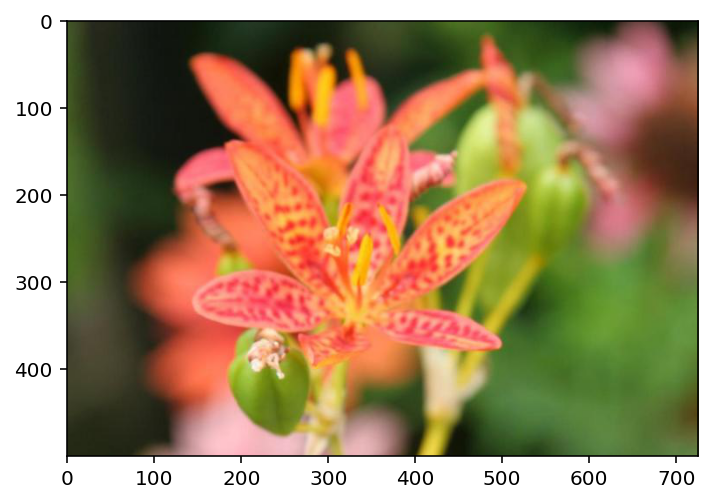

In [ ]:
with Image.open('flower_data/valid/102/image_08006.jpg') as image:
  plt.imshow(image)
model.class_to_idx = image_datasets['train'].class_to_idx

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

In [ ]:
# using method above

img_path = 'flower_data/valid/18/image_04252.jpg'
probs, classes = predict(img_path, model.to(device))
print(probs)
print(classes)
flower_names = [cat_to_name[class_names[e]] for e in classes]
print(flower_names)

[0.8840048313140869, 0.0179277490824461, 0.017038244754076004, 0.016966762021183968, 0.010411751456558704]
[12, 40, 27, 86, 93]
['peruvian lily', 'sword lily', 'carnation', 'desert-rose', 'hippeastrum']


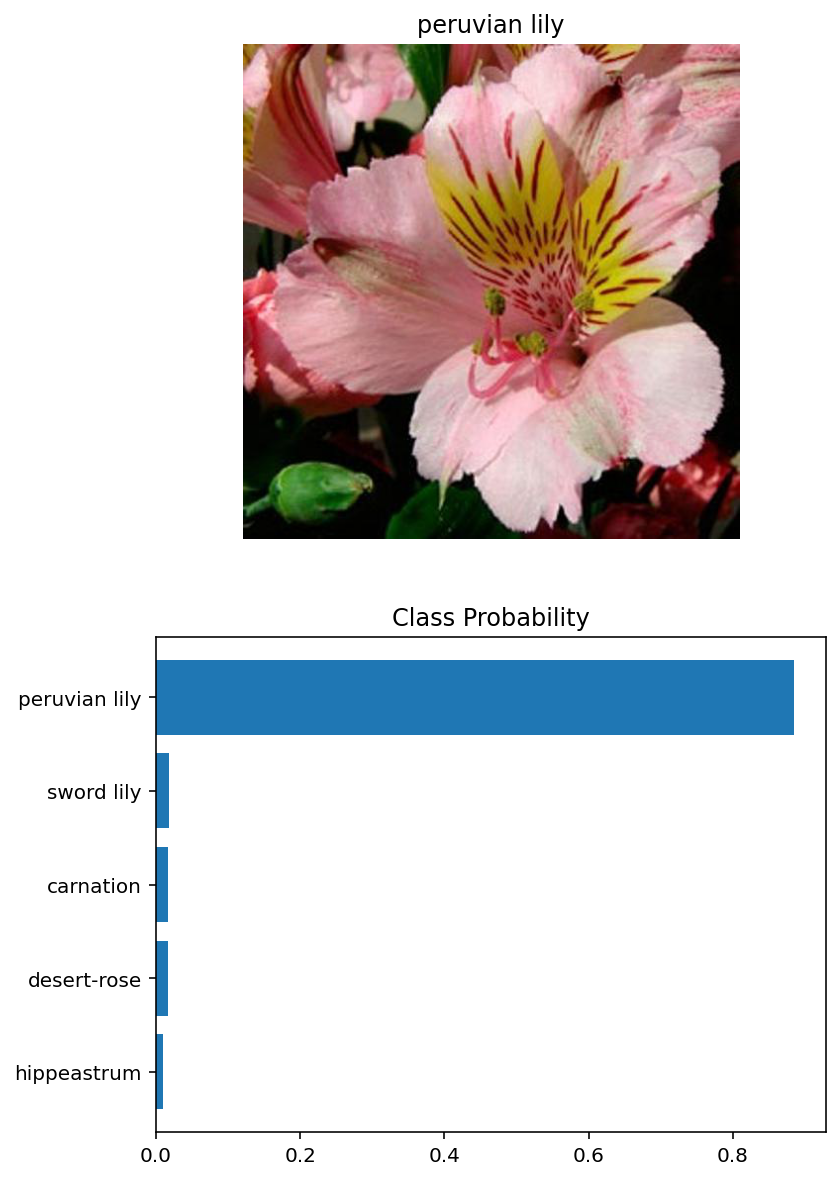

In [ ]:
# TODO: Display an image along with the top 5 classes

def check_sanity(img_path, prob, classes, mapping):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapping[img_path.split('/')[-2]]
    ax1.set_title(flower_name)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')
    
    
# using hte function
check_sanity(img_path, probs, classes, cat_to_name)